# step 0: setup

conda environment: 
    conda create -n hifive hifive python=2 matplotlib bedtools pyBigWig jupyter
    conda activate hifive

directory setup:
    cd qbb2020-answers
    mkdir week9
    mkdir week9/files week9/submits

# step 1: getting the data

its from this paper https://www.nature.com/articles/s41588-018-0218-5
and heres the data https://www.nature.com/articles/s41588-018-0218-5
    
navigated to week9/files, then this command to unzip:
    tar xzf 3DGenomeData.tar.gz

# step 2: Loading in the data
### First, you will need to create a genomic partition file.
This is done using the fends subcommand (fend stands for fragment-end, which derives from the fact that partitioning is typically done with restriction fragments, but you can also use bins encompassing many fragments like in this case). You will be using a genome length file and a binsize of 100Kb with the --binned flag


In [ ]:
hifive fends -L genome/mm9.len --binned 100000 genome_partition

### use that file to create a data file containing counts of interaction reads for each of the pairs of partitions you just specified. 
To do that, use the hic-data subcommand with ‘matrix’ as the data type being loaded. To use this option, you need to give it a generic filename since there is a matrix for each chromosome. In this case, the argument should be data/WT_100kb/raw_\*.mat.

In [ ]:
hifive hic-data -X data/WT_100kb/raw_\*.mat genome_partition hic_output

### You now need a project file, which will track filtering and normalization information. 
This is done with the hic-project subcommand. Without going into too much detail, this will filter out low-coverage rows/columns and calculate a signal-by-distance expectation curve. You will want to use the arguments −f 25 −n 25 −j 100000 to specify that columns/rows are only valid if they have at least 25 observations and that the curve should be estimated over 25 bins with all interaction ranges less than 100000 pooled. These parameter settings are somewhat arbitrarily chosen but the number of distance bins should be much smaller than the number of partition bins, since they are done after log-transforming the distance. And the minimum bin size is to acknowledge that we can’t get reliable counts below some size, but that only applies to fragment-level analysis. Finally, the number of minimum observations is in part based on the resolution of analysis. If this were fragment-level, I would use 3 or 5, but since we have large bins, we expect many more observations per bin.

In [ ]:
hifive hic-project -f 25 -n 25 -j 100000 hic_output project_file

### Finally, you need to normalize the data to remove bias from PCR, GC content, mappability, and fragment length. 
This is done using the hic-normalize subcommand. In this case we are using the express method, which is a variation on matrix balancing. You should only need the arguments -f 25 -w cis to say that you are again filtering by a minimum observation threshold of 25 and only using within-chromosome interactions.

In [ ]:
hifive hic-normalize express -f 25 -w cis project_file

# Step 3: Working with the HiC data
Now that you have normalized HiC data, you will be using the HiFive API to do something with it. The HiFive modules can be loaded into your python code using import hifive, just like any other library. Note that currently, HiFive is only python2.7 compatible. This means that any code you write you should run with the command python2 to be safe, or make it executable and include the python2 shebang (#!/usr/bin/env python2). In order to get out data, you can first load a HiC project with hic=hifive.HiC('<YOUR_PROJECT>', 'r'). Now you can load data in the form of a numpy matrix using the cis_heatmap function. For example, to get data for chromosome 1 at 1Mb resolution (binsize), you can do

In [1]:
import hifive

In [3]:
hic=hifive.HiC('../files/project_file', 'r')

In [53]:
data = hic.cis_heatmap('chr13', 1000000, datatype='fend', arraytype='full', diagonalincluded=True)

Finding fend full array for chr13:1000000-120250001... Done


In [54]:
for value in data:
    value += 1

In [55]:
enrichment = (data[:, :, 0]) / (data[:, :, 1])
enrichment2 = np.log2(data[:, :, 0]) / (data[:, :, 1])

In [56]:
print(enrichment2)

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 7.3198395 5.5259557 4.925292 ]
 [0.        0.        0.        ... 5.5259557 6.3115296 5.6555724]
 [0.        0.        0.        ... 4.925292  5.6555724 8.153038 ]]


In [57]:
enrichment.shape

(1193, 1193)

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

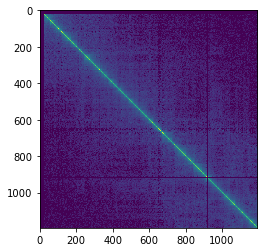

In [61]:
fig, ax = plt.subplots()
im = ax.imshow(enrichment2)
plt.show()

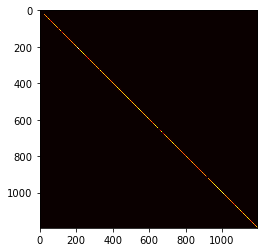

In [62]:
plt.imshow(enrichment, cmap='hot', interpolation='nearest')
plt.show()

# Step 4: Compartment analysis
Next, you will be making use of an experimental (read: not polished and so undocumented) feature of HiFive, compartment calling. This is based on taking the correlation of every row with every column and then doing an eigenvector decomposition on the resulting correlation matrix.

In [29]:
Comp = hifive.hic_domains.Compartment(hic, 100000, chroms=['chr13'], out_fname='tmp.hdf5')
Comp.write_eigen_scores('hic_comp.bed')

Finding expected full array for chr13:3000000-120300000... Done
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arr

In [30]:
X = Comp.positions['chr13']
Y = Comp.eigenv['chr13']

Casting complex values to real discards the imaginary part


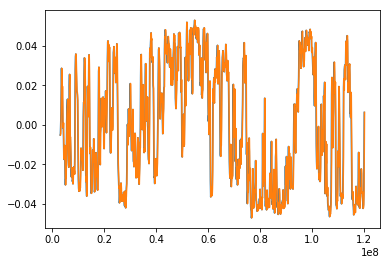

In [33]:
plt.plot(X,Y)
plt.show()

in the terminal:

grep "-" hic_comp.bed >> negatives.bed

bedtools intersect -v -a hic_comp.bed -b negatives.bed >> positives.bed

in the terminal: 

bedtools intersect -a negatives.bed -b ../files/data/WT_fpkm.bed >> neg_gene_express.bed
bedtools intersect -a positives.bed -b ../files/data/WT_fpkm.bed >> pos_gene_express.bed

In [ ]:
bedtools intersect -a ../files/data/WT_fpkm.bed -b negatives.bed > neg_gene_express.bed
bedtools intersect -a ../files/data/WT_fpkm.bed -b positives.bed > pos_gene_express.bed

In [11]:
neg = np.genfromtxt("neg_gene_express.bed")
pos = np.genfromtxt("pos_gene_express.bed")

In [16]:
neg_plot=neg[:,4]
pos_plot=pos[:,4]

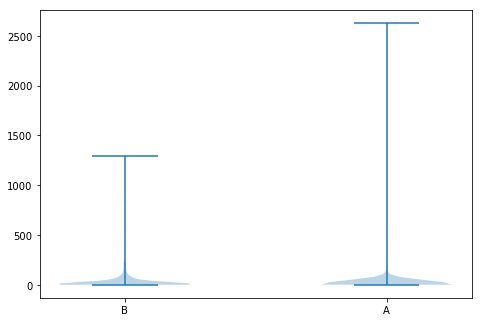

In [19]:
labels = ['B','A']
data_to_plot = [pos_plot, neg_plot]

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.set_xticklabels(labels)
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.arange(1, len(labels) + 1))

bp = ax.violinplot(data_to_plot)

plt.show()